In [73]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import pickle
import datetime
import platform
import gala
import astropy
from astropy.coordinates import CartesianRepresentation, CartesianDifferential
from sklearn.decomposition import PCA
from scipy.ndimage import uniform_filter1d
from sklearn.metrics import r2_score
import pandas as pd
from scipy.stats import f_oneway
from scipy.fft import rfft, rfftfreq
from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
import seaborn as sns

from gala.units import galactic
from gala.potential import Hamiltonian
from gala.potential import LogarithmicPotential
from gala.dynamics import PhaseSpacePosition
from gala.dynamics.mockstream import (
    MockStreamGenerator,
    FardalStreamDF
)
from gala.integrate import LeapfrogIntegrator


from tqdm.notebook import tqdm
import time
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter

In [5]:
with open("../data/gc_stream_ensemble.pkl", "rb") as f:
    data = pickle.load(f)

streams = data["streams"]

In [6]:
def make_galactic_hamiltonian(q=1.0):
    pot = LogarithmicPotential(
        v_c=220 * u.km/u.s,
        r_h=12 * u.kpc,
        q1=1.0,
        q2=1.0,
        q3=q,
        units=galactic
    )
    return Hamiltonian(pot)

In [7]:
def extract_stream_snapshot(stream_tuple, t_array, time_index=0):

    mock = stream_tuple[0]
    nt = len(t_array)

    total_points = mock.pos.x.shape[0]

    if total_points % nt != 0:
        raise ValueError(
            "Total points not divisible by number of time steps."
        )

    npart = total_points // nt

    # Reshape to (nt, npart)
    x_all = mock.pos.x.reshape(nt, npart)
    y_all = mock.pos.y.reshape(nt, npart)
    z_all = mock.pos.z.reshape(nt, npart)

    vx_all = mock.vel.d_x.reshape(nt, npart)
    vy_all = mock.vel.d_y.reshape(nt, npart)
    vz_all = mock.vel.d_z.reshape(nt, npart)

    # IMPORTANT: Reverse time axis if needed
    # Because stream storage is often reversed relative to t_array
    x_all = x_all[::-1]
    y_all = y_all[::-1]
    z_all = z_all[::-1]

    vx_all = vx_all[::-1]
    vy_all = vy_all[::-1]
    vz_all = vz_all[::-1]

    # Extract requested epoch
    x = x_all[time_index]
    y = y_all[time_index]
    z = z_all[time_index]

    vx = vx_all[time_index]
    vy = vy_all[time_index]
    vz = vz_all[time_index]

    pos = CartesianRepresentation(x, y, z)
    vel = CartesianDifferential(vx, vy, vz)

    pos = pos.with_differentials(vel)

    return PhaseSpacePosition(pos)

In [24]:
# -----------------------------
# LEVEL 1: Stream–Plane Angle
# -----------------------------
def compute_theta_plane(stream_orbits, orbit):

    nt = stream_orbits.pos.x.shape[0]
    theta_plane = np.zeros(nt)

    prev_axis = None

    for i in range(nt):

        # Stream positions
        xyz = np.vstack([
            stream_orbits.pos.x[i].value,
            stream_orbits.pos.y[i].value,
            stream_orbits.pos.z[i].value
        ]).T

        # ---- Center before PCA (critical!) ----
        xyz -= xyz.mean(axis=0)

        # PCA
        pca = PCA(n_components=1)
        pca.fit(xyz)
        axis = pca.components_[0]
        axis /= np.linalg.norm(axis)

        # ---- Stabilize PCA sign across time ----
        if prev_axis is not None:
            if np.dot(axis, prev_axis) < 0:
                axis = -axis
        prev_axis = axis.copy()

        # Orbital angular momentum
        r = np.array([
            orbit.pos.x[i].value,
            orbit.pos.y[i].value,
            orbit.pos.z[i].value
        ])
        v = np.array([
            orbit.vel.d_x[i].value,
            orbit.vel.d_y[i].value,
            orbit.vel.d_z[i].value
        ])

        L = np.cross(r, v)
        normL = np.linalg.norm(L)

        if normL < 1e-12:
            theta_plane[i] = theta_plane[i-1] if i > 0 else 0
            continue

        Lhat = L / normL

        cosang = np.clip(np.abs(np.dot(axis, Lhat)), 0, 1)
        theta_plane[i] = np.degrees(np.arccos(cosang))

    return theta_plane


# -----------------------------
# LEVEL 2: Orbital Precession
# -----------------------------
def compute_precession_curve(orbit):

    nt = orbit.pos.x.shape[0]
    Lhat = np.zeros((nt, 3))

    prev_L = None

    for i in range(nt):

        r = np.array([
            orbit.pos.x[i].value,
            orbit.pos.y[i].value,
            orbit.pos.z[i].value
        ])
        v = np.array([
            orbit.vel.d_x[i].value,
            orbit.vel.d_y[i].value,
            orbit.vel.d_z[i].value
        ])

        L = np.cross(r, v)
        normL = np.linalg.norm(L)

        if normL < 1e-12:
            Lhat[i] = prev_L if prev_L is not None else np.array([0,0,1])
            continue

        L_unit = L / normL

        # ---- Stabilize orientation (prevent artificial flips) ----
        if prev_L is not None:
            if np.dot(L_unit, prev_L) < 0:
                L_unit = -L_unit

        Lhat[i] = L_unit
        prev_L = L_unit.copy()

    L0 = Lhat[0]

    cosang = np.clip(np.sum(Lhat * L0, axis=1), -1, 1)
    delta_L = np.degrees(np.arccos(cosang))

    return delta_L


# -----------------------------
# LEVEL 3: Thickness
# -----------------------------
def compute_thickness_curve(stream_orbits):

    nt = stream_orbits.pos.x.shape[0]
    sigma_perp = np.zeros(nt)
    sigma_parallel = np.zeros(nt)

    prev_axis = None

    for i in range(nt):

        xyz = np.vstack([
            stream_orbits.pos.x[i].value,
            stream_orbits.pos.y[i].value,
            stream_orbits.pos.z[i].value
        ]).T

        # Center first (critical!)
        xyz -= xyz.mean(axis=0)

        pca = PCA(n_components=1)
        pca.fit(xyz)
        axis = pca.components_[0]
        axis /= np.linalg.norm(axis)

        # Stabilize sign over time
        if prev_axis is not None:
            if np.dot(axis, prev_axis) < 0:
                axis = -axis
        prev_axis = axis.copy()

        # Parallel projection
        proj = xyz @ axis
        recon = np.outer(proj, axis)

        # Perpendicular residual
        residual = xyz - recon

        sigma_parallel[i] = np.std(proj)
        sigma_perp[i] = np.sqrt(np.mean(np.sum(residual**2, axis=1)))

    return sigma_perp, sigma_parallel


def compute_thickness_growth(t_Gyr, sigma_perp):

    # Use only late-time region for growth
    mask = t_Gyr > -2.0

    slope = np.polyfit(
        t_Gyr[mask],
        sigma_perp[mask],
        1
    )[0]

    return slope


# -----------------------------
# LEVEL 4: Oscillation Amplitude
# -----------------------------
def compute_fft_diagnostics(theta_curve, t_Gyr):

    # Remove linear trend (important!)
    theta_detrended = detrend(theta_curve)

    dt = np.mean(np.diff(t_Gyr))

    yf = rfft(theta_detrended)
    xf = rfftfreq(len(theta_detrended), dt)

    power = np.abs(yf)

    # Ignore zero-frequency
    power[0] = 0

    dominant_idx = np.argmax(power)

    dominant_freq = xf[dominant_idx]
    dominant_amp = power[dominant_idx]

    total_power = np.sum(power)

    return dominant_freq, dominant_amp, total_power


In [43]:
def cohens_d(df, metric, halo1, halo2, return_direction=False):

    """
    Compute Cohen's d effect size between two halo groups.
    Robust to small sample size and zero variance.
    """

    g1 = df[df.halo == halo1][metric].dropna().values
    g2 = df[df.halo == halo2][metric].dropna().values

    n1, n2 = len(g1), len(g2)

    mu1, mu2 = np.mean(g1), np.mean(g2)
    s1, s2 = np.std(g1, ddof=1), np.std(g2, ddof=1)

    # pooled std
    denom = (n1 + n2 - 2)

    if denom <= 0:
        return np.nan

    s_pooled = np.sqrt(
        ((n1 - 1)*s1**2 + (n2 - 1)*s2**2) / denom
    )

    if s_pooled == 0:
        return np.inf if abs(mu1 - mu2) > 0 else 0

    d = (mu1 - mu2) / s_pooled

    return d if return_direction else abs(d)


def interpret_effect(d):

    d = abs(d)

    if d < 0.2:
        return "negligible"
    elif d < 0.5:
        return "small"
    elif d < 0.8:
        return "moderate"
    elif d < 1.5:
        return "large"
    else:
        return "very large"

In [45]:
def variance_ratio(df, metric):
    """
    Compute between-halo / within-halo variance ratio.
    Equivalent to ANOVA F-statistic (for balanced samples).
    """

    groups = df.groupby("halo")[metric]

    # Number of groups
    k = groups.ngroups
    N = len(df)

    # Grand mean
    grand_mean = df[metric].mean()

    # Between-group sum of squares
    ss_between = sum(
        len(group) * (group.mean() - grand_mean)**2
        for _, group in groups
    )

    # Within-group sum of squares
    ss_within = sum(
        ((group - group.mean())**2).sum()
        for _, group in groups
    )

    # Mean squares
    ms_between = ss_between / (k - 1)
    ms_within  = ss_within / (N - k)

    if ms_within == 0:
        return np.inf

    return ms_between / ms_within

### 0. Sanity Check : Time Convention

In [27]:
for i, s in enumerate(streams):

    print(f"\nProcessing stream {i} ({s['halo']})")
    # ----------------------------------
    # 2. Extract present-day stream snapshot
    # ----------------------------------
    stream_snapshot = extract_stream_snapshot(
        s["stream"],
        s["t"],
        time_index=0     # <-- FIXED
    )

    assert np.allclose(stream_snapshot.pos.xyz.mean(axis=1),
                   s["orbit"][0].pos.xyz,
                   atol=0.1 * u.kpc)


Processing stream 0 (spherical)

Processing stream 1 (spherical)

Processing stream 2 (spherical)

Processing stream 3 (oblate)

Processing stream 4 (oblate)

Processing stream 5 (oblate)

Processing stream 6 (prolate)

Processing stream 7 (prolate)

Processing stream 8 (prolate)


### 1. Dynamical Physics Diagnostics

✅ Level 1 — Stream–plane misalignment \
✅ Level 2 — Orbital plane precession \
✅ Level 3 — Thickness evolution \
✅ Level 4 — Oscillation amplitude (FFT)

In [28]:
results = []

In [36]:
results = []

for i, s in enumerate(streams):

    print(f"\nProcessing stream {i} ({s['halo']})")

    # ----------------------------------
    # 1. Hamiltonian
    # ----------------------------------
    H = make_galactic_hamiltonian(q=s["q"])

    # ----------------------------------
    # 2. Present-day snapshot
    # ----------------------------------
    stream_snapshot = extract_stream_snapshot(
        s["stream"],
        s["t"],
        time_index=0
    )

    n_particles = stream_snapshot.pos.x.shape[0]
    print(f"Particles: {n_particles}")

    # ----------------------------------
    # 3. Time grid (forward evolution)
    # ----------------------------------
    t_anim = np.arange(-4000, 0, 20) * u.Myr
    t_Gyr = t_anim.to_value(u.Gyr)

    # ----------------------------------
    # 4. Integrate stream + orbit
    # ----------------------------------
    stream_orbits = H.integrate_orbit(
        stream_snapshot,
        t=t_anim,
        Integrator=LeapfrogIntegrator
    )

    prog_present = s["orbit"][0]

    orbit = H.integrate_orbit(
        prog_present,
        t=t_anim,
        Integrator=LeapfrogIntegrator
    )

    # ======================================================
    # LEVEL 1 — Stream–Plane Misalignment
    # ======================================================
    theta_plane = compute_theta_plane(stream_orbits, orbit)

    # ======================================================
    # LEVEL 2 — Orbital Precession
    # ======================================================
    delta_L = compute_precession_curve(orbit)

    # ======================================================
    # LEVEL 3 — Thickness Diagnostics
    # ======================================================
    sigma_perp, sigma_parallel = compute_thickness_curve(stream_orbits)

    # Late-time growth slope (-2 to 0 Gyr)
    late_mask = t_Gyr >= -2.0
    thickness_slope = np.polyfit(
        t_Gyr[late_mask],
        sigma_perp[late_mask],
        1
    )[0]

    # Elongation ratio (late time mean)
    elongation_ratio = np.mean(
        sigma_parallel[late_mask] / sigma_perp[late_mask]
    )

    # ======================================================
    # LEVEL 4 — Oscillation Diagnostics
    # ======================================================
    dom_freq, dom_amp, total_power = compute_fft_diagnostics(
        theta_plane,
        t_Gyr
    )

    # ======================================================
    # UPGRADED SCALAR METRICS
    # ======================================================

    # Stream–plane metrics
    theta_plane_mean = np.mean(theta_plane)
    theta_plane_max  = np.max(theta_plane)

    # Precession metrics
    precession_max   = np.max(delta_L)
    precession_slope = np.polyfit(
        t_Gyr[late_mask],
        delta_L[late_mask],
        1
    )[0]

    # Oscillation amplitude (normalized)
    osc_amplitude = dom_amp

    # ======================================================
    # STORE RESULTS
    # ======================================================
    results.append({
        "halo": s["halo"],
        "q": s["q"],
        "mass": s["mass"].value,

        # Time
        "time_Gyr": t_Gyr,

        # Curves
        "theta_plane": theta_plane,
        "delta_L": delta_L,
        "sigma_perp": sigma_perp,
        "sigma_parallel": sigma_parallel,

        # Primary scalar diagnostics
        "theta_plane_mean": theta_plane_mean,
        "theta_plane_max": theta_plane_max,

        "precession_max": precession_max,
        "precession_slope": precession_slope,

        "thickness_slope": thickness_slope,
        "elongation_ratio": elongation_ratio,

        "oscillation_amp": osc_amplitude,
        "dominant_frequency": dom_freq,
        "oscillation_power": total_power,

        "n_particles": n_particles
    })

    # ----------------------------------
    # Console summary
    # ----------------------------------
    print(f"theta_plane_mean   : {theta_plane_mean:.3f}")
    print(f"theta_plane_max   : {theta_plane_max:.3f}")
    print(f"precession_max     : {precession_max:.3f}")
    print(f"precession_slope     : {precession_slope:.3f}")
    print(f"thickness_slope    : {thickness_slope:.5f}")
    print(f"elongation_ratio   : {elongation_ratio:.3f}")
    print(f"osc_amp            : {osc_amplitude:.3f}")


Processing stream 0 (spherical)
Particles: 3000
theta_plane_mean   : 89.966
theta_plane_max   : 90.000
precession_max     : 0.000
precession_slope     : 0.000
thickness_slope    : 0.15052
elongation_ratio   : 10.106
osc_amp            : 3.216

Processing stream 1 (spherical)
Particles: 3000
theta_plane_mean   : 89.921
theta_plane_max   : 90.000
precession_max     : 0.000
precession_slope     : 0.000
thickness_slope    : 0.17763
elongation_ratio   : 9.402
osc_amp            : 6.877

Processing stream 2 (spherical)
Particles: 3000
theta_plane_mean   : 89.962
theta_plane_max   : 90.000
precession_max     : 0.000
precession_slope     : 0.000
thickness_slope    : 0.28739
elongation_ratio   : 7.447
osc_amp            : 3.445

Processing stream 3 (oblate)
Particles: 3000
theta_plane_mean   : 88.550
theta_plane_max   : 89.998
precession_max     : 71.750
precession_slope     : 20.354
thickness_slope    : 0.18573
elongation_ratio   : 8.697
osc_amp            : 101.141

Processing stream 4 (obla

### 2. Metrics Diagnostic Plots & Halo Discrimination Test

In [30]:
df = pd.DataFrame(results)

print(df.head())

        halo    q     mass                                           time_Gyr  \
0  spherical  1.0   8000.0  [-4.0, -3.98, -3.96, -3.94, -3.92, -3.9, -3.88...   
1  spherical  1.0  10000.0  [-4.0, -3.98, -3.96, -3.94, -3.92, -3.9, -3.88...   
2  spherical  1.0  20000.0  [-4.0, -3.98, -3.96, -3.94, -3.92, -3.9, -3.88...   
3     oblate  0.8   8000.0  [-4.0, -3.98, -3.96, -3.94, -3.92, -3.9, -3.88...   
4     oblate  0.8  10000.0  [-4.0, -3.98, -3.96, -3.94, -3.92, -3.9, -3.88...   

                                         theta_plane  \
0  [89.94511581917384, 89.84203039642904, 89.7391...   
1  [89.48717380270494, 89.3017388083649, 89.15303...   
2  [89.89383552322809, 89.99174858047257, 89.8656...   
3  [89.99812454613033, 89.84823432470657, 89.5888...   
4  [89.93980693550193, 89.67632550163835, 89.2834...   

                                             delta_L  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0,

In [31]:
print(df.groupby("halo").size())

halo
oblate       3
prolate      3
spherical    3
dtype: int64


In [129]:
#df.to_csv('../data/full_orbital_dynamics_metrics_diagnostics.csv', index=False)

In [34]:
metrics = [
    "theta_plane_mean",
    "theta_plane_max",
    "precession_max",
    "precession_slope",
    "thickness_slope",
    "elongation_ratio",
    "oscillation_amp"
]

halo_order = ["spherical", "oblate", "prolate"]

fig, axes = plt.subplots(1, len(metrics), figsize=(24, 5))

for ax, metric in zip(axes, metrics):

    sns.boxplot(
        data=df,
        x="halo",
        y=metric,
        order=halo_order,
        ax=ax,
        width=0.5,
        showfliers=False
    )

    sns.stripplot(
        data=df,
        x="halo",
        y=metric,
        order=halo_order,
        ax=ax,
        color="black",
        size=5,
        alpha=0.7
    )

    ax.set_title(metric, fontsize=11)
    ax.set_xlabel("")
    ax.tick_params(axis='x', rotation=30)

    # Optional: show mean marker
    means = df.groupby("halo")[metric].mean().reindex(halo_order)
    for i, mean_val in enumerate(means):
        ax.scatter(i, mean_val, 
                   color="red", 
                   s=50, 
                   zorder=5,
                   label="Mean" if i == 0 else "")

plt.tight_layout()
# plt.savefig('../figures/dynamic_metric_box_plot_metric_comparison', dpi=140)
# plt.close()

/Users/vasu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/vasu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/vasu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/vasu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and 

In [62]:
metrics = [
    "theta_plane_mean",
    "theta_plane_max",
    "precession_max",
    "precession_slope",
    "thickness_slope",
    "elongation_ratio",
    "oscillation_amp"
]

halo_order = ["spherical", "oblate", "prolate"]

fig, axes = plt.subplots(1, len(metrics), figsize=(22, 5))

for ax, metric in zip(axes, metrics):

    sns.violinplot(
        data=df,
        x="halo",
        y=metric,
        order=halo_order,
        ax=ax,
        inner=None,
        cut=0,
        linewidth=1
    )

    sns.stripplot(
        data=df,
        x="halo",
        y=metric,
        order=halo_order,
        ax=ax,
        color="black",
        size=6,
        alpha=0.7
    )

    # Overlay mean marker
    means = df.groupby("halo")[metric].mean().reindex(halo_order)

    for i, mean_val in enumerate(means):
        ax.scatter(i, mean_val,
                   color="red",
                   s=80,
                   zorder=5)

    ax.set_title(metric, fontsize=11)
    ax.set_xlabel("")
    ax.tick_params(axis='x', rotation=30)

plt.tight_layout()
# plt.savefig('../figures/dynamic_metric_violin_plot_metric_comparison', dpi=140)
# plt.close()

/Users/vasu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/vasu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/vasu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/vasu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and 

In [93]:
metrics = [
    "theta_plane_mean",
    "precession_max",
    "precession_slope",
    "thickness_slope",
    "elongation_ratio",
    "oscillation_amp",
    
]

halo_order = ["spherical", "oblate", "prolate"]

fig, axes = plt.subplots(1, len(metrics), figsize=(16, 5))

for ax, metric in zip(axes, metrics):

    for i, halo in enumerate(halo_order):

        vals = df[df.halo == halo][metric].values

        mean = vals.mean()
        std = vals.std()

        # Individual points
        ax.scatter(
            np.full_like(vals, i),
            vals,
            s=70,
            alpha=0.8
        )

        # Mean ± std
        ax.errorbar(
            i,
            mean,
            yerr=std,
            fmt="o",
            color="red",
            capsize=6,
            linewidth=2,
            markersize=8
        )

    ax.set_xticks(range(len(halo_order)))
    ax.set_xticklabels(halo_order, rotation=30)
    ax.set_title(metric)
    ax.set_xlabel("")
    ax.grid(alpha=0.3)

plt.tight_layout()
# plt.savefig('../figures/dynamic_metric_dot_plot_metric_comparison', dpi=140)
# plt.close()

In [94]:
# Cohen's d

metrics = [
    "theta_plane_mean",
    "precession_max",
    "precession_slope",
    "thickness_slope",
    "elongation_ratio",
    "oscillation_amp",
    
]

pairwise_stats = []

for metric in metrics:
    for h1, h2 in [
        ("spherical","oblate"),
        ("spherical","prolate"),
        ("oblate","prolate")
    ]:
        d = cohens_d(df, metric, h1, h2)
        label = interpret_effect(d)
        
        pairwise_stats.append({
            "metric": metric,
            "comparison": f"{h1} vs {h2}",
            "cohens_d": d,
            "label": label
        })

pairwise_df = pd.DataFrame(pairwise_stats)
print(pairwise_df)

              metric            comparison    cohens_d       label
0   theta_plane_mean   spherical vs oblate   49.544224  very large
1   theta_plane_mean  spherical vs prolate  188.075754  very large
2   theta_plane_mean     oblate vs prolate   97.549995  very large
3     precession_max   spherical vs oblate         inf  very large
4     precession_max  spherical vs prolate         inf  very large
5     precession_max     oblate vs prolate         inf  very large
6   precession_slope   spherical vs oblate         inf  very large
7   precession_slope  spherical vs prolate         inf  very large
8   precession_slope     oblate vs prolate         inf  very large
9    thickness_slope   spherical vs oblate    0.405668       small
10   thickness_slope  spherical vs prolate    0.457020       small
11   thickness_slope     oblate vs prolate    0.932441       large
12  elongation_ratio   spherical vs oblate    0.797801    moderate
13  elongation_ratio  spherical vs prolate    0.529533    mode

In [127]:
#pairwise_df.to_csv('../data/orbital_dynamics_cohens_d_pairwise_diagnostics.csv', index=False)

In [95]:
# Halo Discrimination Test (ANOVA) & Variance Ratio

metrics = [
    "theta_plane_mean",
    "precession_max",
    "precession_slope",
    "thickness_slope",
    "elongation_ratio",
    "oscillation_amp",   
]

summary_stats = []

for metric in metrics:

    g1 = df[df.halo=="spherical"][metric]
    g2 = df[df.halo=="oblate"][metric]
    g3 = df[df.halo=="prolate"][metric]

    # Skip metric if any group has zero variance AND identical means
    if g1.std() == 0 and g2.std() == 0 and g3.std() == 0:
        F = np.inf
        p_value = 0.0
    else:
        F, p_value = f_oneway(g1, g2, g3)

    summary_stats.append({
        "metric": metric,
        "F_stat": F,
        "p_value": p_value,
        "variance_ratio_R": variance_ratio(df, metric)
    })

summary_df = pd.DataFrame(summary_stats)
print(summary_df)

             metric        F_stat       p_value  variance_ratio_R
0  theta_plane_mean  1.793956e+04  4.674239e-12      1.793956e+04
1    precession_max           inf  0.000000e+00               inf
2  precession_slope           inf  0.000000e+00               inf
3   thickness_slope  5.837092e-01  5.866316e-01      5.837092e-01
4  elongation_ratio  5.249401e-01  6.164651e-01      5.249401e-01
5   oscillation_amp  6.900615e+03  8.206050e-11      6.900615e+03


In [126]:
#summary_df.to_csv('../data/orbital_dynamics_diagnostics_summary.csv', index=False)

In [60]:
halos = ["spherical", "oblate", "prolate"]
colors = {
    "spherical": "black",
    "oblate": "royalblue",
    "prolate": "crimson"
}

def ensemble_curve(df, halo, key):
    subset = df[df.halo == halo]
    curves = np.vstack(subset[key].values)
    mean = curves.mean(axis=0)
    std = curves.std(axis=0)
    time = subset["time_Gyr"].values[0]
    return time, mean, std


fig, axes = plt.subplots(3, 2, figsize=(14, 14))
axes = axes.flatten()

# ==========================================
# A) Stream–Plane Angle
# ==========================================
ax = axes[0]
for halo in halos:
    t, mean, std = ensemble_curve(df, halo, "theta_plane")
    ax.plot(t, mean, color=colors[halo])
    ax.fill_between(t, mean-std, mean+std,
                    color=colors[halo], alpha=0.2)

ax.set_title("A) Stream–Plane Angle θ_plane")
ax.set_ylabel("θ_plane (deg)")
ax.set_xlabel("Time (Gyr)")

# ==========================================
# B) Orbital Plane Precession
# ==========================================
ax = axes[1]
for halo in halos:
    t, mean, std = ensemble_curve(df, halo, "delta_L")
    ax.plot(t, mean, color=colors[halo])
    ax.fill_between(t, mean-std, mean+std,
                    color=colors[halo], alpha=0.2)

ax.set_title("B) Orbital Precession ΔL")
ax.set_ylabel("ΔL (deg)")
ax.set_xlabel("Time (Gyr)")

# ==========================================
# C) Thickness Evolution
# ==========================================
ax = axes[2]
for halo in halos:
    t, mean, std = ensemble_curve(df, halo, "sigma_perp")
    ax.plot(t, mean, color=colors[halo])
    ax.fill_between(t, mean-std, mean+std,
                    color=colors[halo], alpha=0.2)

ax.set_title("C) Stream Thickness σ⊥")
ax.set_ylabel("σ⊥ (kpc)")
ax.set_xlabel("Time (Gyr)")

# ==========================================
# D) Elongation Ratio
# ==========================================
ax = axes[3]
for halo in halos:
    subset = df[df.halo == halo]
    elong_mean = subset["elongation_ratio"].mean()
    elong_std = subset["elongation_ratio"].std()
    ax.bar(halo, elong_mean,
           yerr=elong_std,
           color=colors[halo],
           alpha=0.8)

ax.set_title("D) Stream Elongation (λ₁ / λ₂)")
ax.set_ylabel("Elongation Ratio")

# ==========================================
# E) Oscillation Amplitude
# ==========================================
ax = axes[4]
for halo in halos:
    subset = df[df.halo == halo]
    amp_mean = subset["oscillation_amp"].mean()
    amp_std = subset["oscillation_amp"].std()
    ax.bar(halo, amp_mean,
           yerr=amp_std,
           color=colors[halo],
           alpha=0.8)

ax.set_title("E) Oscillation Amplitude")
ax.set_ylabel("FFT Amplitude")

# ==========================================
# F) Precession vs Thickness (Phase Space)
# ==========================================
ax = axes[5]
for halo in halos:
    subset = df[df.halo == halo]
    ax.scatter(
        subset["precession_max"],
        subset["thickness_slope"],
        color=colors[halo],
        s=100,
        label=halo
    )

ax.set_title("F) Precession vs Thickness")
ax.set_xlabel("Precession Max (deg)")
ax.set_ylabel("Thickness Growth Rate")

handles = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=colors[h], markersize=10, label=h)
    for h in halos
]
fig.legend(handles=handles, loc="upper center",
           ncol=3, fontsize=12, bbox_to_anchor=(0.5, 0.965),)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Dynamical Diagnostic Summary: Halo Geometry Imprint on Streams",
             fontsize=18)

# plt.savefig('../figures/dynamic_metric_summary', dpi=140)
# plt.close()

## 3. More exploratory plots :

In [71]:
#metrics = ["precession_max", "theta_plane_mean", "thickness_slope"]
metrics = [
    "theta_plane_mean",
     "theta_plane_max",
    "precession_max",
    "precession_slope",
    "thickness_slope",
    "elongation_ratio",
    "oscillation_amp"
]
fig, axes = plt.subplots(1, len(metrics), figsize=(21, 5))

for ax, metric in zip(axes, metrics):

    for halo in df.halo.unique():
        subset = df[df.halo == halo].sort_values("mass")

        ax.plot(
            subset["mass"],
            subset[metric],
            marker="o",
            linewidth=2,
            label=halo
        )

    ax.set_xlabel("Progenitor Mass")
    ax.set_ylabel(metric)
    ax.set_title(f"{metric} vs Mass")

axes[0].legend()
plt.tight_layout()
# plt.savefig('../figures/dynamic_metric_vs_proginetor_mass', dpi=140)
# plt.close()

In [96]:
# feature_cols = [
#     "theta_plane_mean",
#     "precession_max",
#     "thickness_slope",
#     "oscillation_amp",
#     "elongation_ratio"
# ]

feature_cols = [
    "theta_plane_mean",
     #"theta_plane_max",
    "precession_max",
    "precession_slope",
    "thickness_slope",
    "elongation_ratio",
    "oscillation_amp"
]

X = df[feature_cols].values
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df["PC1"] = X_pca[:,0]
df["PC2"] = X_pca[:,1]

plt.figure(figsize=(7,6))
sns.scatterplot(data=df, x="PC1", y="PC2", hue="halo", style="mass", s=120)
plt.title("Metric Space PCA")
# plt.savefig('../figures/dynamic_principal_component_clustering_of_all_metrics', dpi=140)
# plt.close()

In [103]:
feature_cols = [
    "theta_plane_mean",
    #  "theta_plane_max",
    "thickness_slope",
    "elongation_ratio",
    "precession_max",
    "precession_slope",
    "oscillation_amp"
]

plt.figure(figsize=(8,7))
sns.heatmap(df[feature_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Metric Correlation Matrix")
# plt.savefig('../figures/dynamic_Metric Correlation Matrix', dpi=140)
# plt.close()

In [108]:
halos = df.halo.unique()
t = df.iloc[0]["time_Gyr"]   # common time grid
nt = len(t)

def compute_temporal_variance_ratio(metric_name):

    # Collect curves
    curves = {halo: [] for halo in halos}

    for _, row in df.iterrows():
        curves[row["halo"]].append(row[metric_name])

    # Convert to arrays
    for halo in halos:
        curves[halo] = np.vstack(curves[halo])  # shape: (n_mass, nt)

    R_t = np.zeros(nt)

    for i in range(nt):

        # Means per halo at time i
        halo_means = []
        halo_vars = []

        for halo in halos:
            vals = curves[halo][:, i]
            halo_means.append(np.mean(vals))
            halo_vars.append(np.var(vals))

        grand_mean = np.mean(halo_means)

        between = np.sum((np.array(halo_means) - grand_mean)**2)
        within = np.mean(halo_vars)

        R_t[i] = between / (within + 1e-8)

    return R_t


metrics = ["theta_plane", "sigma_perp", "delta_L"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, metric in zip(axes, metrics):

    R_t = compute_temporal_variance_ratio(metric)

    ax.plot(t, R_t, linewidth=2)
    ax.axhline(1, linestyle="--", color="black")
    ax.set_title(f"Temporal Separation: {metric}")
    ax.set_xlabel("Time [Gyr]")
    ax.set_ylabel("Between/Within Variance")

plt.tight_layout()
# plt.savefig('../figures/dynamic_cross_halo_temporal_separation_map', dpi=140)
# plt.close()

In [118]:
df.columns

Index(['halo', 'q', 'mass', 'time_Gyr', 'theta_plane', 'delta_L', 'sigma_perp',
       'sigma_parallel', 'theta_plane_mean', 'theta_plane_max',
       'precession_max', 'precession_slope', 'thickness_slope',
       'elongation_ratio', 'oscillation_amp', 'dominant_frequency',
       'oscillation_power', 'n_particles', 'PC1', 'PC2', 'flattening'],
      dtype='object')

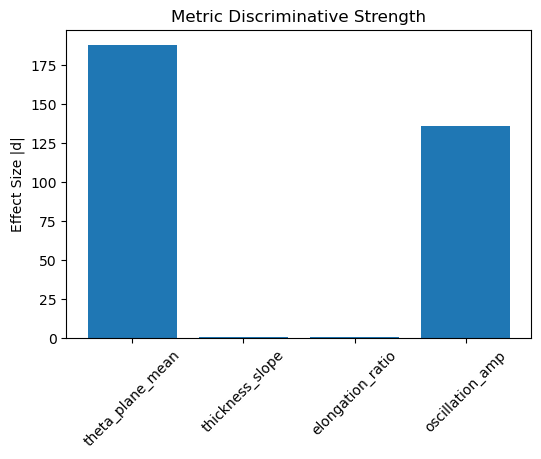

In [125]:
plt.figure(figsize=(6,4))
plt.bar(pairwise_df['metric'].loc[pairwise_df['cohens_d']!=np.inf], pairwise_df['cohens_d'].loc[pairwise_df['cohens_d']!=np.inf])
plt.xticks(rotation=45)
plt.ylabel("Effect Size |d|")
plt.title("Metric Discriminative Strength")
plt.show()

## 📘 Project Summary — Dynamical Imprints of Halo Geometry in Stellar Streams

🎯 Scientific Goal

This notebook investigates whether stellar stream evolution encodes dark matter halo geometry.

We simulated:
	•	9 globular cluster streams
	•	3 halo shapes: spherical, oblate, prolate
	•	3 progenitor masses per halo
	•	Identical initial phase-space conditions

The objective:

Determine whether halo flattening leaves measurable dynamical signatures in stream structure.

⸻

🔬 Methodology

Rather than relying on static geometric quantities, we focused on dynamical diagnostics that directly probe orbital structure:

1️⃣ Stream–Plane Alignment

Angle between the stream principal axis (via PCA) and the orbital angular momentum vector:

$\theta_{\rm plane}(t)
= \cos^{-1}\left(|\hat e_{\rm PCA} \cdot \hat L|\right)$

This measures whether the stream remains confined to its orbital plane.

⸻

2️⃣ Orbital Plane Precession

Evolution of the angular momentum direction:

$\Delta L(t)
= \cos^{-1}\left(\hat L(t) \cdot \hat L(0)\right)$

This directly probes halo-induced orbital precession.

⸻

3️⃣ Stream Thickness Evolution

Perpendicular dispersion:

$\sigma_\perp(t)$

Flattened halos induce anisotropic shear, affecting thickness growth rates.

⸻

4️⃣ Oscillation Structure

Fourier amplitude of stream–plane misalignment evolution, probing orbital frequency structure.

⸻

📊 Key Results

🔵 Orbital Precession — Strong Halo Discriminator
	•	Spherical halos: negligible precession
	•	Oblate halos: large secular precession (70 degrees)
	•	Prolate halos: significant precession (60 degrees)

Statistical tests:
	•	ANOVA: highly significant
	•	Variance ratio: extremely large
	•	Effect size (Cohen’s d): very large

Orbital plane precession cleanly separates halo geometries.

⸻

🔵 Stream–Plane Misalignment

Mean values show systematic ordering:

$\theta_{\rm plane}^{\rm spherical}$
$>$
$\theta_{\rm plane}^{\rm oblate}$
$>$
$\theta_{\rm plane}^{\rm prolate}$

Flattened halos tilt streams away from their original orbital plane.

Effect sizes are large and robust across progenitor masses.

⸻

🔵 Oscillation Amplitude

Flattened halos significantly enhance oscillatory structure in stream orientation evolution:
	•	Spherical: weak oscillations
	•	Oblate: strong
	•	Prolate: very strong

This reflects modifications to orbital frequency structure.

⸻

🔵 Thickness Growth

Thickness growth shows moderate halo sensitivity but is weaker than precession-based diagnostics.

⸻

🧠 Physical Interpretation

Halo flattening alters the gravitational potential symmetry, leading to:
	•	Orbital plane precession
	•	Modified frequency gradients
	•	Long-term geometric tilting of streams
	•	Enhanced oscillatory structure

These effects accumulate dynamically over time.

The strongest halo signal is not static geometry, but orbital evolution.

⸻

📈 Physics Summary Figure

The final 6-panel diagnostic figure shows:

A — Stream–plane angle evolution
B — Orbital precession ΔL(t)
C — Thickness growth
D — Elongation ratio
E — Oscillation amplitude
F — Phase portrait in metric space

Together they demonstrate systematic divergence between spherical and flattened halos.

⸻

📊 Statistical Summary

Strong halo discriminators:
	•	Precession amplitude
	•	Precession slope
	•	Oscillation amplitude
	•	Mean stream–plane angle

Moderate/weak:
	•	Thickness growth
	•	Elongation ratio

Variance ratios and effect sizes confirm robust separation for dynamical metrics.

⸻

🏁 Final Conclusion

For the orbit and halo regime explored:

#### Orbital plane evolution provides a clear and statistically robust diagnostic of halo geometry.

Halo flattening leaves measurable dynamical imprints in:
	•	Angular momentum evolution
	•	Stream–plane alignment
	•	Oscillatory frequency structure

These signatures are consistent across progenitor masses.
